# Generando un tren de pulsos de radar pulsado

Un radar pulsado es aquel capaz de medir tanto rango (distancia) como velocidad, haciendo uso de la transmisión de un pulso y leyendo el reflejo del mismo en alguna superficie. El pulso reflejado tardara un determinado delta de tiempo (diferencia entre que se transmite y se recibe) el cual hace valer la siguiente expresión:   
 ### <center> $R = \frac{\Delta t*c}{2}$            
  Donde $R$ es el rango y $c$ es la velocidad de propagación de la onda, que al ser electromagnética corresponde a la velocidad de la luz. Con esta información y midiendo el $\Delta t$, podemos calcular una estimación del rango.

In [1]:
import adi
import numpy as np
from commpy.filters import rrcosfilter
from sk_dsp_comm import digitalcom as dc
import scipy.signal as signal
import matplotlib.pyplot as plt
from scipy.fftpack import fftfreq
from scipy.linalg import bandwidth

In [2]:
#------------------------------- SDR Parameter Configuration -------------------------------

Uri              = "ip:192.168.1.34" 
SamplingRate     = 6e6           # Sample rate RX and TX paths[Samples/Sec]
Loopback         = 2           # 0=Disabled, 1=Digital, 2=RF

TxLOFreq         = 918e6         # Carrier frequency of TX path [Hz] RELLENAR CON LA FREC. DE PORTADORA ASIGNADA
TxAtten          = -30           # Attenuation applied to TX path, valid range is -90 to 0 dB [dB]
TxRfBw           = 4e6           # Bandwidth of front-end analog filter of TX path [Hz]

RxLOFreq         = TxLOFreq      # Carrier frequency of RX path [Hz]
GainControlModes = "slow_attack" # Receive path AGC Options: slow_attack, fast_attack, manual
RxHardwareGain   = 0             # Gain applied to RX path. Only applicable when gain_control_mode is set to 'manual'    
RxRfBw           = TxRfBw        # Bandwidth of front-end analog filter of RX path [Hz] 
RxBufferSize     = 2**20-1

Definimos variables como el PRI (pulse repetition interval) y su inversa, PRF (pulse repetition frequency). Por otro lado, determinamos la frecuencia de sampling y de transmisión dentro del pulso. El valor del PRI nos dará el rango máximo calculable por nuestro radar, ya que, nuestro pulso debe ser transmitido y recibido antes de volver a transmitir el segundo pulso. Es por esto que la máxima distancia calculable es:   
### <center> $Max Range = \frac{c}{2} * PRI $.

En nuestro caso, la distancia máxima es de 150000 [m] o 150 [km] para un PRI de 0.001 [s] y una PRF de 1[kHz].

In [3]:
PRI = 0.001 #[s] 
PRF = 1/PRI
potencia_señal = 1

beta = 0.3
sps = 8 
span = 6
pulses = 100

sample_f = SamplingRate
step = 1/SamplingRate
f1 = 500e3
samples = pulses*int(PRI/step)

En las siguientes celdas generamos nuestra señal a transmitir ,nuestro vector de tiempo y se realiza la configuración de la SDR haciendo uso de la libreria adi. Modulamos el tren de pulsos con la siguiente función senoidal

\begin{equation}
    Tx_I = \sin(2* \pi * f_1 * t)
\end{equation}

\begin{equation}
    Tx_Q = \sin(2* \pi * f_1 * t)
\end{equation}

\begin{equation}
    Tx = Tx_I + jTx_Q = \sin(2* \pi * f_1 * t) + j * \sin(2* \pi * f_1 * t)
\end{equation}


In [4]:
t = np.linspace(0,(samples-1)*step,samples)
pulse_length = 0.00005 #[s] => 0.5 ms
Tx_I = 20*np.sin(2*np.pi*f1*t) + 20
Tx_Q = 20*np.sin(2*np.pi*f1*t + np.pi/2) + 20
zeros = np.zeros(len(t))
ones = np.ones(int(pulse_length/step))

for i in range(0,len(Tx_I),int(PRI/step)):
      zeros[i:i+len(ones)] = ones

/home/jupyter-user_comdig23_3/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


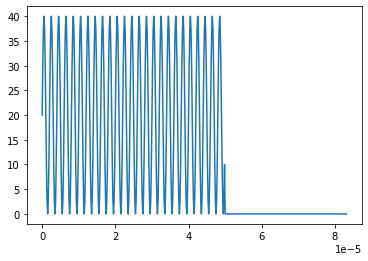

In [5]:
Tx_I = Tx_I * zeros # parte real de la señal
Tx_Q = Tx_Q * zeros #parte imaginaria
Tx = Tx_I + 1j * Tx_Q

plt.plot(t[:500],Tx[:500])

In [6]:
#-----------------------------------SDR Configurations-------------------------------
sdr             = adi.Pluto(Uri)
sdr.sample_rate = SamplingRate
sdr.loopback    = Loopback
#Tx:
sdr.tx_lo                 = int(TxLOFreq)
sdr.tx_hardwaregain_chan0 = TxAtten 
sdr.tx_rf_bandwidth       = int(TxRfBw)
sdr.tx_buffer_size        = samples
sdr.tx_cyclic_buffer      = True
# Rx:
sdr.rx_lo                   = int(RxLOFreq)
sdr.gain_control_mode_chan0 = GainControlModes
sdr.rx_rf_bandwidth         = int(RxRfBw)
sdr.rx_cyclic_buffer        = False
sdr.rx_buffer_size          = RxBufferSize
sdr.rx_enabled_channels = [0]

# Transmisión y Recepción

In [7]:
#------------------------------- Transmitter ------------------------------- 

sdr.tx(Tx_I*2**14)

In [8]:
#------------------------------- Receiver ------------------------------- 
rxSignal = sdr.rx()/2**14

rows, cols = (pulses, int(PRI/step))
recieved_signal = [[0 for i in range(cols)] for j in range(rows)] 
for i in range(rows):
    recieved_signal[i] = rxSignal[i*int(PRI/step):i*int(PRI/step)+int(PRI/step)]

Luego de transmitir la señal, utilizamos la antena receptora para hacer la lectura correspondiente del pulso reflejado. En este caso tomamos de a 50 muestras de la señal reflejada guardadas en una matriz con 10 filas y n columnas, siendo n igual a la cantidad de muestras que hay en un determinado pulso (equivalente al tiempo PRI).

### Simulación 

Se trata de recrear la situación de recepción de acuerdo a la distancia a la que estaria un determinado objeto con su correspondiente retarto, ruido y atenuación.

Para la generación del ruido blanco gaussiano se comenzo con la siguiente formula para el cálculo de la **potencia de la señal**: 


\begin{equation}
    \text{SNR} = \frac{P_s}{P_n}
\end{equation}

\begin{equation}
    {P_s} = \frac{\sum_0^M Tx(t)^2}{M}
\end{equation}

De esta manera conseguimos la energía media de cada una de las muestras generadas, para luego dividirlo por nuestro **SNR linealizado** y obtener la **potencia del ruido**:

\begin{equation}
    {P_n} = \frac{P_s}{SNR}
\end{equation}


Debido a que la potencia del ruido es equivalente a su varianza, entonces generamos un vector de señales de ruido con media 0 y varianza igual a la potencia del ruido calculada:
\begin{equation}
   {N(μ,σ^2)} = {N(0,P_n)}
\end{equation}

3.3356409519815205e-05
1.5178932768808214e-14


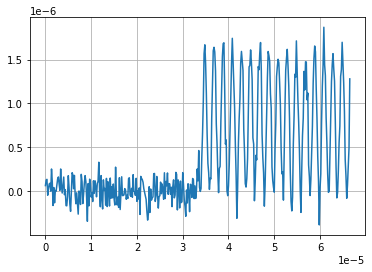

In [6]:
#Reflected pulse
distance = 5000 #[m]
returned_pulse = (1/distance**2)*Tx_I[:int(pulse_length/step)+1] #Se guarda un pulso de los transmitidos con su atenuación
#returned_pulse = Tx_I[:int(pulse_length/step)+1]
ret_pulse = np.ones(len(returned_pulse))
for i in range(len(returned_pulse)):
    ret_pulse[i] = returned_pulse[len(returned_pulse)-1-i] #Se guarda el pulso reflejado

delta_t = (distance*2/299792458) #Calculo del delta t correspondiente
print(delta_t)
Rx_I = np.zeros(pulses*int(PRI/step)+1) #100 pulsos recibidos
sample_shift = int(delta_t/step) #Cuantas muestras se debe shiftear el pulso recibido de acuerdo a la distancia que representa

for i in range(pulses):
    Rx_I[i*int(PRI/step)+sample_shift:i*int(PRI/step)+sample_shift+int(pulse_length/step)+1] = ret_pulse #Señal shifteada

snr_dB = 5  # SNR en decibelios
snr_linear = 10 ** (snr_dB / 10.0)  # Convertir SNR a escala lineal

# Generar ruido gaussiano
potencia_ruido = np.sum(np.abs(Rx_I) ** 2) / len(Tx_I) / snr_linear
ruido = np.random.normal(0, np.sqrt(potencia_ruido), len(t)+1)

print(potencia_ruido)
Rx_I = Rx_I + ruido #Se le agrega ruido

plt.grid(True)
plt.plot(t[:400],Rx_I[:400])
plt.show()

### Transformada Rápida de Fourier (FFT)

Utilizando las técnicas de la transformada rápida de Fourier hacemos el análisis de la respuesta en frecuencia de la señal transmitida para verificar su ancho de banda.

In [7]:
#FFT
f_f_salida = np.abs(np.fft.fft(Tx_I))/samples
f_plot = 2 * f_f_salida[0:int(samples/2+1)]
f_plot[0] = f_plot[0]/2
f_step = sample_f/samples
frec = np.linspace(0,(samples-1)*f_step,samples)
frec_plot = frec[0:int(samples/2+1)]

### Matched Filter
Hacemos uso de un matched filter con respuesta al impulso igual al pulso transmitido y hacemos convolucionar la señal recibida con el mismo. Esto para mejorar la relación señal ruido (SNR), ya que es mucho mayor la correlación entre el pulso y las partes de la señal recibida equivalentes al pulso reflejado que al ruido, amplificando mucho mas la señal y haciendo más fácil su lectura. Además, sabemos que la señal recibida presenta una gran atenuación frente a la transmitida debido a la pérdida de energía en el traslado de la misma o de la distancia al objeto reflector.

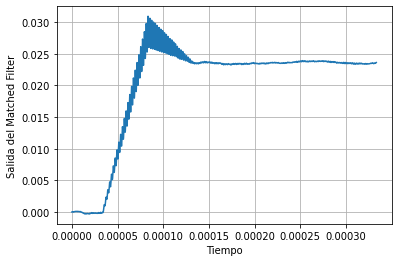

In [8]:
#Matched filter used to maximize SNR ratio
def matched_filter(pulse,signal):
    #debo conjugar la señal o utilizar el pulso conjugado
    return np.convolve(np.conjugate(pulse),signal,mode='full')
rows, cols = (pulses, int(PRI/step))
con =  [[0 for i in range(cols)] for j in range(rows)]
for i in range(rows):
       con[i] = matched_filter(Tx_I[0:int(PRI/step)+1]+100,Rx_I[i*int(PRI/step):i*int(PRI/step)+int(PRI/step)])

        
plt.xlabel('Tiempo')
plt.ylabel('Salida del Matched Filter')
plt.grid(True)
plt.plot(t[:2000],con[40][:2000])
plt.show()

### Cálculo y estimación del rango
Haciendo uso de las 50 muestras tomadas, y de hacer pasar la señal recibida por el matched filter, es tiempo de calcular los distintos $\Delta t$ para cada muestra. Luego de hacer esto se calcula la media y se determina el valor estimado por el radar.

In [9]:
#Delta time detector
#max = rxSignal[0]
index_max_j = 0
max_con = []            
for i in range(rows):
    max_i = 0
    for j in range(len(con[i])):
        if(con[i][j]>max_i):
            max_i = con[i][j]
            index_max_j = j - int(pulse_length/step)
    #print(index_max_j)
    max_con.append(t[index_max_j])

stimation_delta_t = sum(max_con)/len(max_con)
print("Stimated delta time: " + str(stimation_delta_t) + "[s]")
stimation_range = stimation_delta_t*299792458/2
print("Stimated range: " + str(stimation_range) + "[m]")

Stimated delta time: 3.333333333333326e-05[s]
Stimated range: 4996.540966666656[m]


## Gráfico: varianza en la estimación del rango vs SNR 

### Gráficos de la señal

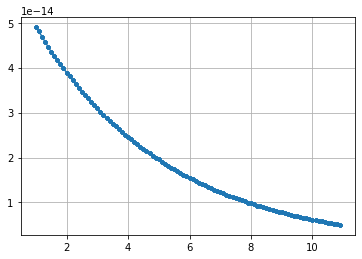

In [12]:
nmbr_times = 10
delta_time_stimations = []
var = []
snr = []
samples_p = [[0 for i in range(cols)] for j in range(nmbr_times)]

Rx_I_aux = np.zeros(nmbr_times*int(PRI/step)+1) #10 pulsos recibidos
sample_shift = int(delta_t/step) #Cuantas muestras se debe shiftear el pulso recibido de acuerdo a la distancia que representa

for i in range(nmbr_times):
    Rx_I_aux[i*int(PRI/step)+sample_shift:i*int(PRI/step)+sample_shift+int(pulse_length/step)+1] = ret_pulse #Señal shifteada

np.random.seed(123)

for i in range(100): #number of runs to make graph
    delta_time_stimations = []  #Delta time stimations for a noise with var of i*10**-7
    
    
    for j in range(nmbr_times):  #number of samples per run
        snr_dB = 1 + i*(0.1)  # SNR en decibelios
        snr_linear = 10 ** (snr_dB / 10.0)  # Convertir SNR a escala lineal

        # Generar ruido gaussiano
        potencia_ruido = np.var(Rx_I) / snr_linear
        ruido = np.random.normal(0, np.sqrt(potencia_ruido), len(t)+1)
        
        samples_p[j] = (Rx_I_aux[:int(PRI/step)]*10**5)  + ruido[:int(PRI/step)] 
        
    
  #  con2 =  [[0 for i in range(cols)] for j in range(nmbr_times)] #matrix with convolutioned signals
    
    #for j in range(nmbr_times): #passing through the matched filter
     #   con2[j] = matched_filter(Tx_I[0:int(pulse_length/step)+1],samples_p[j])
    
    index_max_j_p = 0
    max_con_p = []            
    
    for z in range(nmbr_times): #loops through every delta time stimation in each run
        max_i = 0 
        for j in range(len(samples_p[z])):
            if(samples_p[z][j]>max_i):
                max_i = samples_p[z][j]
                index_max_j_p = j #- int(pulse_length/step)
        delta_time_stimations.append(t[index_max_j_p])
        max_con_p.append(t[index_max_j_p])
        snr.append(snr_dB)
        var.append(np.std(ruido)**2)


plt.plot(snr,var,'.-')
plt.grid(True)
plt.show()

### Cota CRLB
Utilizada como cota de menor varianza posible en las muestras para una serie de valores de SNR lineales, la cota Cramér-Rao Lower Bound (CRLB) funciona como medida de funcionamiento de los radares, ya que, se busca siempre obtener los valores de varianza mas cercanos a dicha cota posibles. En el siguiente gráfico se representa la misma.

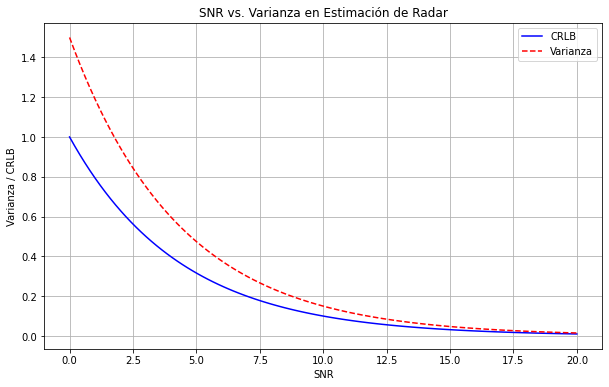

In [16]:
# Simular datos
snr_values = np.linspace(0, 20, 100)  # SNR en una escala lineal 
crlb_values = 1 / (10**(snr_values / 10))  # CRLB simulada para este ejemplo (ajusta según tus necesidades)
variance_values = crlb_values * 1.5  # Varianza simulada 

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Plot de la CRLB
plt.plot(snr_values, crlb_values, label='CRLB', color='blue')

# Plot de la varianza simulada
plt.plot(snr_values, variance_values, label='Varianza', color='red', linestyle='dashed')

# Añadir etiquetas y leyenda
plt.xlabel('SNR')
plt.ylabel('Varianza / CRLB')
plt.title('SNR vs. Varianza en Estimación de Radar')
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

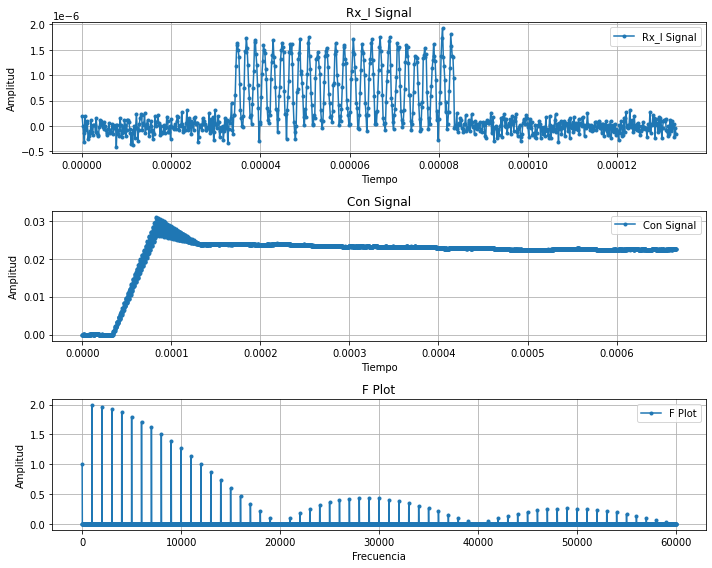

In [29]:
# Plot signal
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))

# Ajustes estilísticos para el primer gráfico
ax1.plot(t[0:800], Rx_I[0:800], '.-', label='Rx_I Signal')
ax1.set_title('Rx_I Signal')
ax1.set_xlabel('Tiempo')
ax1.set_ylabel('Amplitud')
ax1.grid(True)
ax1.legend()

# Ajustes estilísticos para el segundo gráfico
ax2.plot(t[0:4000], con[5][0:4000], '.-', label='Con Signal')
ax2.set_title('Con Signal')
ax2.set_xlabel('Tiempo')
ax2.set_ylabel('Amplitud')
ax2.grid(True)
ax2.legend()

# Ajustes estilísticos para el tercer gráfico
ax3.plot(frec_plot[0:6000], f_plot[0:6000], '.-', label='F Plot')
ax3.set_title('F Plot')
ax3.set_xlabel('Frecuencia')
ax3.set_ylabel('Amplitud')
ax3.grid(True)
ax3.legend()

# Ajustes generales para el diseño de la figura
plt.tight_layout()
plt.show()

In [18]:
# Since it is not possible to turn off Tx, it is configured to transmit at low power and on a different frequency than Rx.
sdr.tx_destroy_buffer()
TxAtten  = -70
RxLOFreq = 2400e6
sdr.tx(np.zeros(1024))

In [19]:
# Destroy radio object
del(sdr)

## Bibliografía

https://www.britannica.com/technology/radar/Pulse-radar
https://www.researchgate.net/publication/267869273_DESIGN_OF_MATCHED_FILTER_FOR_RADAR_APPLICATIONS